# Ensemble 模型策略

本notebook将整合之前实现的各种模型，构建一个基于ensemble模型的策略。主要步骤包括：

1. 数据获取与预处理
2. 特征工程（技术指标构建）
3. 数据集划分（训练集、验证集、测试集）
4. 模型集成：
   - 线性回归（Day1）
   - 随机森林（Day2）
   - XGBoost（Day3）
   - MLP（Day4）
5. 模型权重优化
6. 策略回测与评估

## 0. 导入依赖包

In [28]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import talib  # 如果报错找不到ta-lib，需先安装并确认本地编译环境
import sys
from dotenv import load_dotenv, find_dotenv
# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")
# Load it explicitly
load_dotenv(dotenv_path)
# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from data_processing import load_data_year, flatten_yf_columns, standardize_columns
from plotting import plot_results
from strategy.buy_and_hold import BuyAndHoldStrategy
from back_test import run_backtest
import backtrader as bt
# 设置显示选项
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False
import random
# 固定全局随机种子
np.random.seed(42)
random.seed(42)

## 1. 数据准备与特征工程

In [2]:
# 获取数据
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)
print(f"获取数据时间范围：{start_date.strftime('%Y-%m-%d')} 到 {end_date.strftime('%Y-%m-%d')}")
ticker = 'TSLA'
data = yf.download(ticker, start=start_date, end=end_date)

获取数据时间范围：2020-03-14 到 2025-03-13
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data = flatten_yf_columns(data)
data = standardize_columns(data)

In [4]:
print(data.info())              # 看看总共有多少行、列，各字段数据类型
print(data.head(10))           # 查看前10行，确认最早日期
print(data.tail(10))           # 查看后10行，确认最晚日期
print(data.index.min())  # DataFrame中最早的日期
print(data.index.max())  # DataFrame中最晚的日期


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-03-16 to 2025-03-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1255 non-null   float64
 1   high    1255 non-null   float64
 2   low     1255 non-null   float64
 3   open    1255 non-null   float64
 4   volume  1255 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.8 KB
None
             close    high     low    open     volume
Date                                                 
2020-03-16 29.6713 32.9913 29.4780 31.3000  307342500
2020-03-17 28.6800 31.4567 26.4000 29.3340  359919000
2020-03-18 24.0813 26.9907 23.3673 25.9333  356793000
2020-03-19 28.5093 30.1333 23.8973 24.9800  452932500
2020-03-20 28.5020 31.8000 28.3860 29.2133  424282500
2020-03-23 28.9527 29.4667 27.3667 28.9067  246817500
2020-03-24 33.6667 34.2460 31.6000 31.8200  343428000
2020-03-25 35.9500 37.1333 34.0740 36.3500  318340500
2020-03-26 35.2107 37

## 1.2. 加入技术指标

构建两个简单的因子：
1. 动量因子：过去5日涨跌幅
2. 成交量比值：最近5日均量vs最近10日均量
3. 先举几个常用指标的例子：RSI, MACD, 布林带。

In [5]:
# 复制数据
df = data.copy()
# 动量因子: 过去5日涨跌幅
df['momentum_5'] = df['close'] / df['close'].shift(5) - 1
# 成交量因子: (最近5日平均成交量) / (最近10日平均成交量) - 1
df['vol_ratio'] = (df['volume'].rolling(5).mean()) / (df['volume'].rolling(10).mean()) - 1
# 计算RSI (默认周期14)
df['RSI_14'] = talib.RSI(df['close'], timeperiod=14)
# 布林带
upper, middle, lower = talib.BBANDS(
    df['close'],
    timeperiod=20,
    nbdevup=2,
    nbdevdn=2,
    matype=0
)
df['BB_upper'] = upper
df['BB_middle'] = middle
df['BB_lower'] = lower
# 也可以增加其他指标，比如ATR, CCI等，根据需要添加
df.dropna(inplace=True)  # 丢掉因子无法计算的前几行
factors = ['momentum_5', 'vol_ratio' ,'RSI_14','BB_upper','BB_lower']
# 看看加上技术指标后的DataFrame
print(df[['close'] + factors].tail(5))


              close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                  
2025-03-06 263.4500     -0.0656     0.0620 26.9042  393.4019  253.4611
2025-03-07 262.6700     -0.1035     0.0087 26.7602  388.5007  247.1973
2025-03-10 222.1500     -0.2196     0.0368 20.5942  389.9048  231.8462
2025-03-11 230.5800     -0.1524     0.0812 24.4922  388.9695  220.7665
2025-03-12 248.0900     -0.1111     0.1207 31.9633  387.6891  214.0059


## 3. 目标变量的定义

定义下期1日收益率作为目标变量。

添加目标变量后的数据预览：
             close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                 
2020-04-13 43.3967      0.3561    -0.0236 70.1564   41.4042   24.5249
2020-04-14 47.3260      0.3751     0.0475 73.9119   44.2006   23.4940
2020-04-15 48.6553      0.3380     0.0749 75.0555   46.7505   22.9416
2020-04-16 49.6807      0.3578     0.1159 75.9319   48.6161   23.6360
2020-04-17 50.2593      0.3157     0.1495 76.4351   50.6157   23.8114
2020-04-20 49.7573      0.1466     0.1144 74.9707   52.1107   24.4419
2020-04-21 45.7813     -0.0326    -0.0262 64.4403   52.6247   25.6108
2020-04-22 48.8073      0.0031    -0.1078 68.1114   53.7665   25.9830
2020-04-23 47.0420     -0.0531    -0.1902 63.9628   54.5341   26.3247
2020-04-24 48.3433     -0.0381    -0.1874 65.6249   55.3793   26.7927


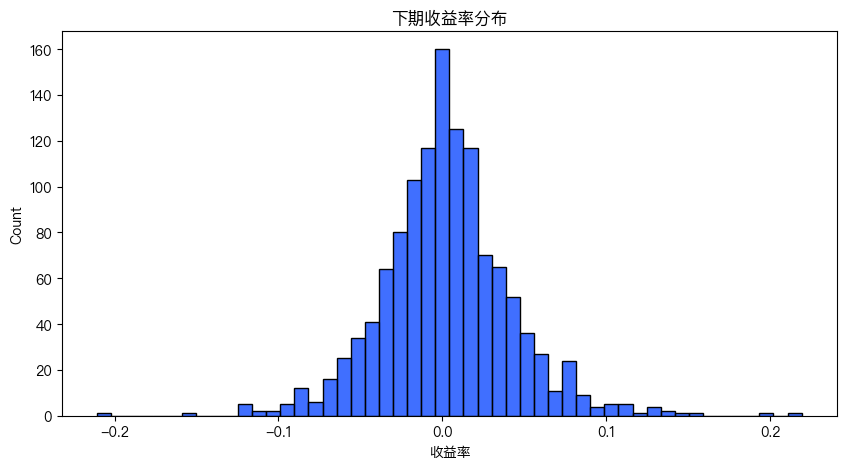

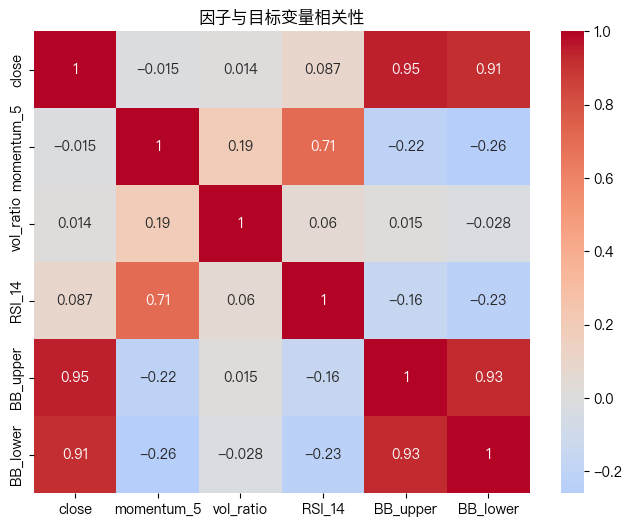

目标变量的均值=0.0022025471360195233
目标变量的方差=0.03982585069525267


In [6]:
# 计算下期收益率
df['future_ret_1d'] = df['close'].pct_change().shift(-1)
# 去掉NaN值
df.dropna(inplace=True)
print("添加目标变量后的数据预览：")
print(df[['close']+factors].head(10))
# 绘制目标变量分布
plt.figure(figsize=(10, 5))
sns.histplot(df['future_ret_1d'], bins=50)
plt.title('下期收益率分布')
plt.xlabel('收益率')
plt.show()
# 计算因子与目标变量的相关性
corr = df[['close']+factors].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('因子与目标变量相关性')
plt.show()
print(f"目标变量的均值={np.mean(df['future_ret_1d'])}")
print(f"目标变量的方差={np.std(df['future_ret_1d'])}")

## 4. 划分训练集与测试集

按照时间顺序，使用前60%的数据作为训练集，中20%作为验证集，后20%作为测试集。

训练集范围: 2020-04-13 00:00:00 → 2023-03-21 00:00:00
验证集范围: 2023-03-22 00:00:00 → 2024-03-14 00:00:00
测试集范围: 2024-03-15 00:00:00 → 2025-03-11 00:00:00

训练集样本数: 741
验证集样本数: 247
测试集样本数: 247


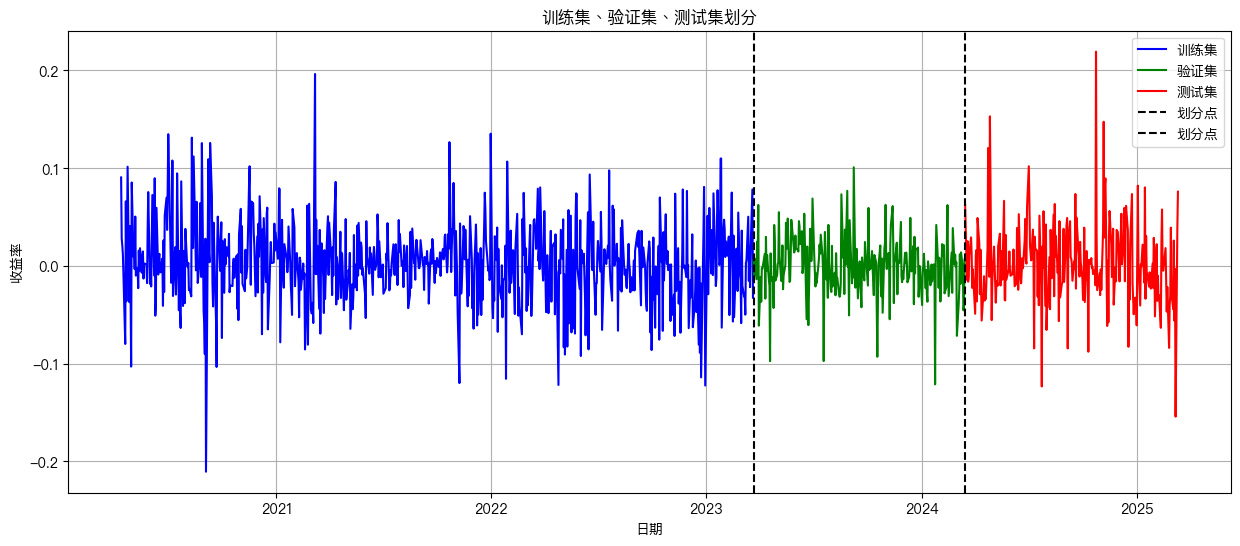

In [7]:
# 计算分割点
train_idx = int(len(df) * 0.6)
valid_idx = int(len(df) * 0.8)
split_date_1 = df.index[train_idx]
split_date_2 = df.index[valid_idx]
train_data = df.iloc[:train_idx].copy()
val_data = df.iloc[train_idx:valid_idx].copy()
test_data = df.iloc[valid_idx:].copy()
print("训练集范围:", train_data.index.min(), "→", train_data.index.max())
print("验证集范围:", val_data.index.min(), "→", val_data.index.max())
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())
print("\n训练集样本数:", len(train_data))
print("验证集样本数:", len(val_data))
print("测试集样本数:", len(test_data))
# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['future_ret_1d'], label='训练集', color='blue')
plt.plot(val_data.index, val_data['future_ret_1d'], label='验证集', color='green')
plt.plot(test_data.index, test_data['future_ret_1d'], label='测试集', color='red')
plt.axvline(split_date_1, color='black', linestyle='--', label='划分点')
plt.axvline(split_date_2, color='black', linestyle='--', label='划分点')
plt.title('训练集、验证集、测试集划分')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
print(f"训练集大小: {len(train_data)}")
print(f"验证集大小: {len(val_data)}")
print(f"测试集大小: {len(test_data)}")

训练集大小: 741
验证集大小: 247
测试集大小: 247


# 3. Buy & Hold

In [9]:
# 若想看最优参数的详细回测日志，可再手动调用:
bh_result, bh_cerebro = run_backtest(
    ticker=ticker,
    df=test_data,
    start_date=start_date,
    end_date=end_date,
    strategy=BuyAndHoldStrategy,
    initial_cash=100000,
    print_log=True,  # 这次打开日志
    timeframe=bt.TimeFrame.Days,
    compression=1
)

初始资金: 100000.00
2024-03-15 00:00:00 [买入] 执行买入并持有策略: 价格=163.57, 数量=580
2024-03-18 00:00:00 [成交] 买单执行: 价格=170.07, 数量=580
2025-03-11 00:00:00 [回测结束] Buy & Hold 策略最终市值: 134997.16
2025-03-11 00:00:00 [回测结束] 总收益率: 35.00%
回测结束资金: 134997.16
=== 回测分析报告 ===
夏普比率: 0.7735
最大回撤比例: 53.46%
最大回撤金额(自定义): 149471.80
累计收益率: 30.01%
年化收益率: 35.82%
=== 交易详情 ===
总交易笔数: 1
胜率: 0 / 1


In [10]:
# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型
if not hasattr(np, 'object'):
    np.object = object  # 兼容 backtrader_plotting 的引用

/var/folders/lb/hgfyjd8d6jdgjkfcksmwvbd80000gq/T/ipykernel_22869/454311182.py:5: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'object'):


In [11]:
plot_results(bh_cerebro)

Loading BokehJS ...

## 4. 模型训练与超参数优化

In [12]:
features = factors
X_train = train_data[features].values
y_train = train_data['future_ret_1d'].values
X_val = val_data[features].values
y_val = val_data['future_ret_1d'].values
X_test = test_data[features].values
y_test = test_data['future_ret_1d'].values

## 4.1 训练线性模型

In [13]:
import copy
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
######################################
# 1. 建立 Pipeline（先缩放，再线性回归）
######################################
pipeline_lr = Pipeline([
    # ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
######################################
# 2. 定义线性模型的超参数搜索范围
#    这里只调节 fit_intercept 参数，你可以根据需要添加其他模型或参数
######################################
param_grid_lr = {
    'lr__fit_intercept': [True, False]
}
######################################
# 3. 遍历所有参数组合，寻找最佳线性模型（在验证集上评估）
######################################
best_score_lr = float('-inf')
best_params_lr = None
best_pipeline_lr = None
for params in ParameterGrid(param_grid_lr):
    pipeline_lr.set_params(**params)
    pipeline_lr.fit(X_train, y_train)
    # 在验证集上进行预测和评估
    valid_pred_lr = pipeline_lr.predict(X_val)
    valid_r2_lr = r2_score(y_val, valid_pred_lr)
    if valid_r2_lr > best_score_lr:
        best_score_lr = valid_r2_lr
        best_params_lr = params
        # 复制当前 pipeline，保存最佳模型
        best_pipeline_lr = copy.deepcopy(pipeline_lr)
        print("更新：", best_score_lr, best_params_lr)
print("最佳参数：", best_params_lr)
######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_lr = best_pipeline_lr.predict(X_train)
y_pred_test_lr  = best_pipeline_lr.predict(X_test)
train_mse_lr = mean_squared_error(y_train, y_pred_train_lr)
test_mse_lr  = mean_squared_error(y_test, y_pred_test_lr)
train_r2_lr  = r2_score(y_train, y_pred_train_lr)
test_r2_lr   = r2_score(y_test, y_pred_test_lr)
print("==== 线性模型 - 训练集 ====")
print("MSE:", train_mse_lr)
print("R2: ", train_r2_lr)
print("==== 线性模型 - 测试集 ====")
print("MSE:", test_mse_lr)
print("R2: ", test_r2_lr)
# 查看训练后的回归系数和截距
print("Coefficients:", best_pipeline_lr.named_steps['lr'].coef_)
print("Intercept:", best_pipeline_lr.named_steps['lr'].intercept_)


更新： 0.01437919229387119 {'lr__fit_intercept': True}
更新： 0.015420523178606094 {'lr__fit_intercept': False}
最佳参数： {'lr__fit_intercept': False}
==== 线性模型 - 训练集 ====
MSE: 0.0016890928696469377
R2:  0.028335449754056108
==== 线性模型 - 测试集 ====
MSE: 0.0017871230505083686
R2:  0.010780101301515743
Coefficients: [-3.97937026e-02  3.18477633e-02  3.06941651e-04 -3.23051459e-05
 -2.72487741e-05]
Intercept: 0.0


## 4.2 训练随机森林

In [14]:
import copy
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
# 同时 features 变量也定义了各特征名称
######################################
# 1. 建立 Pipeline（可选标准化，对 RF 来说不一定必要，但便于与其他模型比较）
######################################
pipeline_rf = Pipeline([
    # ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])
######################################
# 2. 定义 RF 的超参数搜索范围
######################################
param_grid_rf = {
    'rf__n_estimators': [1000],
    'rf__max_depth': [3, 5, 10, 20],
    'rf__min_samples_split': [2, 5, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4, 8],
    'rf__max_features': [0.1, 0.3, 'sqrt']
}
######################################
# 3. 遍历所有参数组合，在验证集上寻找最佳 RF 模型
######################################
best_score_rf = float('-inf')
best_params_rf = None
best_pipeline_rf = None
for params in ParameterGrid(param_grid_rf):
    # 设置参数并训练模型
    pipeline_rf.set_params(**params)
    pipeline_rf.fit(X_train, y_train)
    # 在验证集上进行预测并计算 R2 得分
    valid_pred_rf = pipeline_rf.predict(X_val)
    valid_r2_rf = r2_score(y_val, valid_pred_rf)
    if valid_r2_rf > best_score_rf:
        best_score_rf = valid_r2_rf
        best_params_rf = params
        best_pipeline_rf = copy.deepcopy(pipeline_rf)
        print("更新：", best_score_rf, best_params_rf)
print("最佳参数：", best_params_rf)
######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_rf = best_pipeline_rf.predict(X_train)
y_pred_test_rf  = best_pipeline_rf.predict(X_test)
train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)
test_mse_rf  = mean_squared_error(y_test, y_pred_test_rf)
train_r2_rf  = r2_score(y_train, y_pred_train_rf)
test_r2_rf   = r2_score(y_test, y_pred_test_rf)
print("==== 训练集 ====")
print("MSE:", train_mse_rf)
print("R2 :", train_r2_rf)
print("==== 测试集 ====")
print("MSE:", test_mse_rf)
print("R2 :", test_r2_rf)
######################################
# 5. 查看特征重要性
######################################
feature_importances = best_pipeline_rf.named_steps['rf'].feature_importances_
for f, imp in zip(features, feature_importances):
    print(f"Feature: {f}, Importance: {imp:.4f}")
# 按重要性排序输出
sorted_idx = np.argsort(feature_importances)[::-1]
print("\nSorted Feature Importances:")
for idx in sorted_idx:
    print(f"{features[idx]} -> {feature_importances[idx]:.4f}")


更新： 0.006081622366325812 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 1000}
更新： 0.006693216751230802 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 1000}
更新： 0.0076023565576545105 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 1000}
更新： 0.0077442202686249795 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 20, 'rf__n_estimators': 1000}
更新： 0.009274598008820578 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 1000}
更新： 0.00957816245966292 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 1000}
更新： 0.009810242187923701 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samp

# 3.3 训练XGBoost

In [15]:
import copy
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
# 同时 features 列表也定义了各特征名称
######################################
# 1. 建立 Pipeline（XGBoost 通常不需要标准化）
######################################
pipeline_xgb = Pipeline([
    # 如果需要标准化，可取消注释下面这一行：
    # ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, verbosity=0))
])
######################################
# 2. 定义 XGBoost 的超参数搜索范围
######################################
param_grid_xgb = {
    'xgb__n_estimators': [100, 500, 1000],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 20],
    'xgb__subsample': [1.0, 0.8]
}
######################################
# 3. 遍历所有参数组合，在验证集上寻找最佳 XGBoost 模型
######################################
best_score_xgb = float('-inf')
best_params_xgb = None
best_pipeline_xgb = None
for params in ParameterGrid(param_grid_xgb):
    pipeline_xgb.set_params(**params)
    pipeline_xgb.fit(X_train, y_train)
    # 在验证集上进行预测并计算 R² 得分
    valid_pred_xgb = pipeline_xgb.predict(X_val)
    valid_r2_xgb = r2_score(y_val, valid_pred_xgb)
    if valid_r2_xgb > best_score_xgb:
        best_score_xgb = valid_r2_xgb
        best_params_xgb = params
        best_pipeline_xgb = copy.deepcopy(pipeline_xgb)
        print("更新：", best_score_xgb, best_params_xgb)
print("最佳参数：", best_params_xgb)
######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_xgb = best_pipeline_xgb.predict(X_train)
y_pred_test_xgb  = best_pipeline_xgb.predict(X_test)
train_mse_xgb = mean_squared_error(y_train, y_pred_train_xgb)
test_mse_xgb  = mean_squared_error(y_test, y_pred_test_xgb)
train_r2_xgb  = r2_score(y_train, y_pred_train_xgb)
test_r2_xgb   = r2_score(y_test, y_pred_test_xgb)
print("==== XGBoost - 训练集 ====")
print("MSE:", train_mse_xgb)
print("R2: ", train_r2_xgb)
print("==== XGBoost - 测试集 ====")
print("MSE:", test_mse_xgb)
print("R2: ", test_r2_xgb)
######################################
# 5. 查看特征重要性
######################################
feature_importances_xgb = best_pipeline_xgb.named_steps['xgb'].feature_importances_
for f, imp in zip(features, feature_importances_xgb):
    print(f"Feature: {f}, Importance: {imp:.4f}")
# 按重要性排序输出
sorted_idx_xgb = np.argsort(feature_importances_xgb)[::-1]
print("\nSorted Feature Importances (XGBoost):")
for idx in sorted_idx_xgb:
    print(f"{features[idx]} -> {feature_importances_xgb[idx]:.4f}")


更新： -0.007270856752297439 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
更新： 0.0022478950762674366 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
更新： 0.0024220702010102624 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 500, 'xgb__subsample': 1.0}
更新： 0.0028199603233218795 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
最佳参数： {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
==== XGBoost - 训练集 ====
MSE: 0.0013524411968075076
R2:  0.22199709036440585
==== XGBoost - 测试集 ====
MSE: 0.001841500656542895
R2:  -0.019319342560303765
Feature: momentum_5, Importance: 0.1647
Feature: vol_ratio, Importance: 0.2087
Feature: RSI_14, Importance: 0.2009
Feature: BB_upper, Importance: 0.2017
Feature: BB_lower, Importance: 0.2240

Sorted Feature Importances (XGBoost):
BB_lower -> 

# 3.4 训练MLP

In [16]:
import copy
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
######################################
# 1. 建立 Pipeline（先缩放，再 MLP 回归）
######################################
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(random_state=42, max_iter=1000))
])
######################################
# 2. 定义 MLP 的超参数搜索范围
######################################
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(64, 64), (128, 128), (256, 256)],
    'mlp__alpha': [1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init': [1e-4, 1e-3, 1e-2],
    'mlp__solver': ['adam', 'sgd']
}
######################################
# 3. 遍历所有参数组合，寻找最优 MLP 模型（在验证集上评估）
######################################
best_score = float('-inf')
best_params = None
best_pipeline_mlp = None
for params in ParameterGrid(param_grid_mlp):
    # 设置 Pipeline 的参数
    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    # 在验证集上进行预测和评估
    valid_pred = pipeline.predict(X_val)
    valid_r2 = r2_score(y_val, valid_pred)
    if valid_r2 > best_score:
        best_score = valid_r2
        best_params = params
        # 复制当前 pipeline，保存最佳模型
        best_pipeline_mlp = copy.deepcopy(pipeline)
        print('updated', best_score, best_params)
print("Best Params:", best_params)
######################################
# 4. 使用最优模型在训练集和测试集上评估
######################################
y_pred_train_mlp = best_pipeline_mlp.predict(X_train)
y_pred_test_mlp  = best_pipeline_mlp.predict(X_test)
train_mse_mlp = mean_squared_error(y_train, y_pred_train_mlp)
test_mse_mlp  = mean_squared_error(y_test, y_pred_test_mlp)
train_r2_mlp  = r2_score(y_train, y_pred_train_mlp)
test_r2_mlp   = r2_score(y_test, y_pred_test_mlp)
print("==== MLP - 训练集 ====")
print("MSE:", train_mse_mlp)
print("R2: ", train_r2_mlp)
print("==== MLP - 测试集 ====")
print("MSE:", test_mse_mlp)
print("R2: ", test_r2_mlp)

updated -6.715064465465408 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.0001, 'mlp__solver': 'adam'}
updated -0.41421395423402996 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'adam'}
updated -0.2184150205591111 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.07622754968453371 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (128, 128), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.001959548464392391 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated 0.005052016566378326 {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Best Params: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'ada

## 4. 模型集成与权重优化（用凸优化）

In [18]:
import numpy as np
import cvxpy as cp
from sklearn.metrics import mean_squared_error, r2_score
def optimize_weights_constrained(
    models,
    X_val,
    y_val,
    sum_to_1=True,     # 是否约束权重和=1
    nonnegative=True,  # 是否要求所有权重>=0
    alpha_l1=0.0,      # L1正则系数
    alpha_l2=0.0,      # L2正则系数
    verbose=True
):
    """
    用凸优化方式在验证集上寻找一组最优权重，使得加权后的预测最小化 MSE
    （或等效地最大化 R²），并可选地加入 L1/L2 正则，还可选地约束权重和=1、权重>=0。
    参数：
    - models: 传入已训练好的各个模型列表
    - X_val, y_val: 验证集特征和目标
    - sum_to_1: Boolean, 若为 True，则加上 sum(w) == 1 的约束
    - nonnegative: Boolean, 若为 True，则加上 w >= 0 的约束
    - alpha_l1, alpha_l2: L1、L2 正则化系数
    - verbose: 是否打印约束求解的一些信息
    返回：
    - w_opt: 优化得到的权重向量 (numpy array)
    - score_r2: 用该权重在验证集上得到的 R² 分数
    """
    # 1) 先得到在验证集上的预测矩阵 predictions: shape (N, M)
    predictions = np.column_stack([model.predict(X_val) for model in models])
    N, M = predictions.shape
    # 2) 定义优化变量 w: 大小 M
    #    如果 nonnegative=True，则需要 w >= 0
    if nonnegative:
        w = cp.Variable(M, nonneg=True)
    else:
        w = cp.Variable(M)
    # 3) 定义约束列表 constraints
    constraints = []
    if sum_to_1:
        # sum(w) == 1
        constraints.append(cp.sum(w) == 1)
    # 4) 定义目标函数（最小化 MSE + 正则项）
    #    MSE 可以写成 sum_squares(y_val - predictions @ w)
    residual = y_val - predictions @ w
    obj_mse = cp.sum_squares(residual)
    # 若要加 L1 正则：alpha_l1 * ||w||_1
    # 若要加 L2 正则：alpha_l2 * ||w||_2^2
    obj_reg = 0
    if alpha_l1 > 0:
        obj_reg += alpha_l1 * cp.norm1(w)
    if alpha_l2 > 0:
        obj_reg += alpha_l2 * cp.norm2(w)**2
    # 最终目标：Minimize(MSE + 正则)
    objective = cp.Minimize(obj_mse + obj_reg)
    # 5) 构建并求解凸优化问题
    problem = cp.Problem(objective, constraints)
    result = problem.solve(verbose=verbose)  # 如果想看更多solver输出，可设 verbose=True
    # 6) 拿到最优权重 w_opt
    w_opt = w.value
    # 计算该组合在验证集上的 r2_score
    y_val_pred = predictions @ w_opt
    score_r2 = r2_score(y_val, y_val_pred)
    if verbose:
        print(f"Optimal objective (MSE + reg) = {problem.value:.6f}")
        print("Optimized weights:", w_opt)
        print(f"sum of weights = {w_opt.sum():.4f}")
        print(f"R2 on validation set = {score_r2:.4f}")
    return w_opt, score_r2
# =======================
# 使用示例
# =======================
# 假设你已经在训练集上训练好了 4 个模型：models = [m1, m2, m3, m4]
# 并且有验证集 X_val, y_val
# 比如我们想：
#   - 权重和 = 1
#   - 权重 >= 0
#   - 加一点儿 L2 正则以防止极端权重
#   - 不打印太详细的求解日志 => verbose=False
w_constrained, r2_constrained = optimize_weights_constrained(
    models=[best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp],
    X_val=X_val,
    y_val=y_val,
    sum_to_1=True,
    nonnegative=True,
    alpha_l1=0.0,
    alpha_l2=1e-3,
    verbose=False
)
print("得到的约束权重 =", [f"{num:0.2f}" for num in w_constrained])
print("验证集 R² =", r2_constrained)


得到的约束权重 = ['0.41', '0.40', '0.00', '0.19']
验证集 R² = 0.020732349991320564


In [26]:
# 1. 得到测试集上各模型的预测矩阵
predictions_test = np.column_stack([model.predict(X_test) for model in [best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp]])
# 2. 利用之前优化得到的权重 w_constrained 对测试集预测进行加权组合
y_test_pred = predictions_test @ w_constrained
# 3. 计算测试集上的 R² 分数
r2_test = r2_score(y_test, y_test_pred)
print("测试集 R² =", r2_test)


测试集 R² = 0.006075388329110809


## 5. Emsemble策略实现与回测

In [19]:
import backtrader as bt
# 自定义成交量指标，把成交量数据单独显示在子图中
class MyVolumeIndicator(bt.Indicator):
    """
    简单示例，把data的volume包装成一个单独的子图指标。
    """
    lines = ('vol',)
    plotinfo = dict(subplot=True, plotname='Volume')  # 让它单独开子图
    def __init__(self):
        self.lines.vol = self.data.volume
class MLEnsembleStrategy(bt.Strategy):
    params = (
        ('target_percent', 0.98),   # 目标仓位百分比
    )
    def __init__(self,models,weights):
        self.models = models
        self.weights = weights
        # 关闭主图中Data自带的Volume绘制
        self.data.plotinfo.plotvolume = False
        # 自定义成交量指标以及其SMA指标
        self.myvol = MyVolumeIndicator(self.data)
        self.vol_5 = bt.indicators.SMA(self.myvol.vol, period=5)
        self.vol_5.plotinfo.subplot = True
        self.vol_10 = bt.indicators.SMA(self.myvol.vol, period=10)
        self.vol_10.plotinfo.subplot = True
        # 添加其它因子指标
        # 价格动量指标：计算5日价格百分比变化
        self.momentum_5 = bt.indicators.PercentChange(self.data.close, period=5)
        # RSI指标，14日周期
        self.rsi_14 = bt.indicators.RSI(self.data.close, period=14)
        # 布林带指标，默认20日均线和2倍标准差，返回上轨、均线和下轨
        self.bb = bt.indicators.BollingerBands(self.data.close)
        self.last_trade_type = None  # 记录上一次交易类型（buy/sell）
        self.value_history_dates = []
        self.value_history_values = []
    def next(self):
        # 计算各个因子的当前值
        momentum = self.momentum_5[0]
        vol_ratio = (self.vol_5[0] / self.vol_10[0] - 1) if self.vol_10[0] != 0 else 0
        rsi = self.rsi_14[0]
        bb_upper = self.bb.top[0]  # 布林带上轨
        bb_lower = self.bb.bot[0]  # 布林带下轨
        # 构建特征向量：注意顺序需要与模型训练时一致
        X = [[momentum, vol_ratio, rsi, bb_upper, bb_lower]]
         # 获取各模型的预测值，假设每个模型输出一个标量预测
        predictions = np.array([model.predict(X)[0] for model in self.models])
        # print("Predictions:", predictions)
        # 加权平均得到集成预测
        pred_ret = np.sum(predictions * self.weights)
        # print("Ensemble Prediction:", pred_ret)
        # 获取当前持仓状态
        current_position = self.getposition().size
        if pred_ret > 0 and current_position == 0:
            # 只有当当前没有仓位时，才执行买入
            self.order_target_percent(target=self.p.target_percent)
            self.last_trade_type = "BUY"
            print(f"{self.datas[0].datetime.date(0)} => BUY signal, pred_ret={pred_ret:.6f}")
        elif pred_ret <= 0 and current_position > 0:
            # 只有当当前有仓位时，才执行卖出
            self.order_target_percent(target=0.0)
            self.last_trade_type = "SELL"
            print(f"{self.datas[0].datetime.date(0)} => SELL signal, pred_ret={pred_ret:.6f}")
        # 只在交易执行时打印仓位信息
        if self.last_trade_type:
            print(f"Current position size: {self.getposition().size}, Value: {self.broker.getvalue()}")
        dt = self.data.datetime.date(0)
        self.value_history_dates.append(dt)
        self.value_history_values.append(self.broker.getvalue())

In [20]:
# 若想看多模型集成策略的详细回测日志，可调用如下回测函数:
ml_ensemble_result, ml_ensemble_cerebro = run_backtest(
    ticker=ticker,
    df=test_data,
    start_date=start_date,
    end_date=end_date,
    strategy=MLEnsembleStrategy,
    initial_cash=100000,
    strategy_params={
        'models': [best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp],
        # 'weights': optimal_weights,   # 归一化后的各模型权重
        'weights': w_constrained,   # 归一化后的各模型权重
        'target_percent': 0.98,       # 目标仓位百分比
    },
    print_log=True,  # 打开详细回测日志
)
# 如需进一步查看回测结果或可视化结果，可进一步操作 ml_ensemble_cerebro 或 ml_ensemble_result


初始资金: 100000.00
2024-04-12 => BUY signal, pred_ret=0.002784
Current position size: 0, Value: 100000.0
Current position size: 572, Value: 94863.26853092041
Current position size: 572, Value: 92363.63132388916
Current position size: 572, Value: 91414.1092291626
Current position size: 572, Value: 88256.66678531494
Current position size: 572, Value: 86609.31272037353
Current position size: 572, Value: 83749.31272037353
Current position size: 572, Value: 85253.66678531494
Current position size: 572, Value: 95235.07376773682
Current position size: 572, Value: 99839.66678531494
Current position size: 572, Value: 98758.58713443603
Current position size: 572, Value: 113493.31272037353
Current position size: 572, Value: 107332.87027652588
Current position size: 572, Value: 105450.99411685791
Current position size: 572, Value: 105462.42783267822
Current position size: 572, Value: 106137.39237125244
Current position size: 572, Value: 108179.42783267822
Current position size: 572, Value: 104204.029

In [21]:
# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型
if not hasattr(np, 'object'):
    np.object = object  # 兼容 backtrader_plotting 的引用

In [22]:
plot_results(ml_ensemble_cerebro)

## 6. 比较策略和Buy&Hold

In [23]:
results = ml_ensemble_cerebro.run()  # cerebro.run() 返回一个列表，每个元素是一个策略实例
ml_strategy_instance = results[0]  # 如果你只有一个策略，就取第一个
results = bh_cerebro.run()
bh_strategy_instance = results[0]

2024-04-12 => BUY signal, pred_ret=0.002784
Current position size: 0, Value: 100000.0
Current position size: 572, Value: 94863.26853092041
Current position size: 572, Value: 92363.63132388916
Current position size: 572, Value: 91414.1092291626
Current position size: 572, Value: 88256.66678531494
Current position size: 572, Value: 86609.31272037353
Current position size: 572, Value: 83749.31272037353
Current position size: 572, Value: 85253.66678531494
Current position size: 572, Value: 95235.07376773682
Current position size: 572, Value: 99839.66678531494
Current position size: 572, Value: 98758.58713443603
Current position size: 572, Value: 113493.31272037353
Current position size: 572, Value: 107332.87027652588
Current position size: 572, Value: 105450.99411685791
Current position size: 572, Value: 105462.42783267822
Current position size: 572, Value: 106137.39237125244
Current position size: 572, Value: 108179.42783267822
Current position size: 572, Value: 104204.02957828369
Current

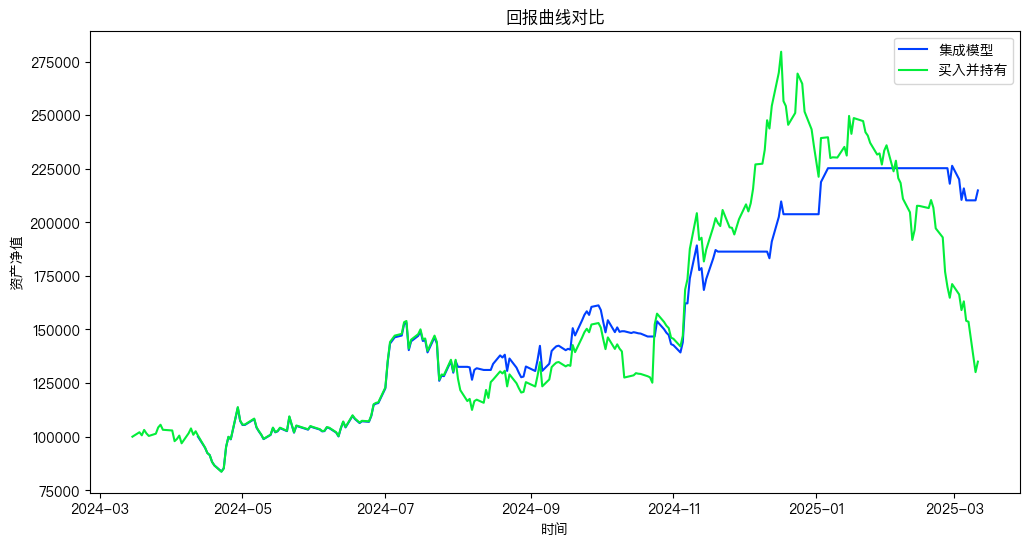

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(ml_strategy_instance.value_history_dates, ml_strategy_instance.value_history_values, label='集成模型')
plt.plot(bh_strategy_instance.value_history_dates, bh_strategy_instance.value_history_values, label='买入并持有')
plt.xlabel('时间')
plt.ylabel('资产净值')
plt.title('回报曲线对比')
plt.legend()
plt.show()


O1的建议

我先整体看了一下你的实现流程，大体思路是没问题的：  
1. **分别对多个模型（LR、RF、XGB、MLP）进行超参数搜索并在验证集上选出相对最佳的模型**。  
2. **在验证集上用线性回归(带 `positive=True`) 做了一次简单的 Stacking 来得到各模型的权重**，并且将权重做了归一化。  
3. **最后在 backtrader 策略中使用这组权重对下一步收益进行预测，如果预测 > 0 则买入，<=0 则卖出**。  

**这种整体思路是完全可行的**，如果你只是想做一个“验证性”或“快速原型”实验，这个写法基本OK。下面我从几个角度给一些可改进或需要注意的地方，供你参考：  

---

## 1. 超参数调优部分

### 1.1 搜索方式
你现在用 `ParameterGrid` 做的是**穷举式**(Grid Search)，当网格很大时会非常耗时。  
- 对于**树模型**（如 RF、XGB）或**神经网络**（MLP）来说，超参数空间往往比较大，穷举式搜索实际并不高效。  
- 在实际项目中，更常见做法是使用**随机搜索 (RandomizedSearchCV)** 或 **贝叶斯优化 (Bayesian Optimization)** 等更智能的搜索手段。  
- **交叉验证**也是一个考虑点，你现在是简单地在固定验证集上做对比，如果数据量大而且时间序列相对稳定，问题还不算大；但如果数据易变，或者想要更稳健的模型选择，通常会配合**时间序列交叉验证 (TimeSeriesSplit)** 来做模型/参数选择。

### 1.2 时间序列的注意事项
由于是金融时间序列预测，许多同学会采用**滚动窗口**或**多次切片**的方式做类似交叉验证，以确保不会存在“数据泄漏”。  
- 你当前是 `train: 0~0.6`, `valid: 0.6~0.8`, `test: 0.8~1.0` 的简单三段切分方式，这个也够用，但要注意：  
  - 如果在“验证集”上反复试很多超参数组合，依然会存在某种**过拟合验证集**的风险。  
  - 更稳健的做法：可以用**多段滚动**的验证来多次评估模型，再取平均排名等方式确定最佳参数，或者干脆把验证集留作最终测评，采用**交叉验证**来挑选参数。

### 1.3 线性回归的参数过少
你的 `param_grid_lr = {'lr__fit_intercept': [True, False]}` 非常简单，其实几乎没调……  
- 如果你想让 LR 有一些正则化约束，可以用 **Ridge / Lasso / ElasticNet** 之类，它们会有正则项系数可以调。  
- 当然，如果你只是想和别的模型做对比，它也能发挥“线性基准”的作用，问题不大。

---

## 2. Ensemble（Stacking）的部分

### 2.1 训练方式
目前的做法是：  
1. 先在训练集上训练所有一层模型；  
2. 在验证集上做预测，把验证集预测拼成 `(n_samples, n_models)`；  
3. 用线性回归（带正系数）去拟合验证集的 `y_val`，得到各模型的正权重；  
4. 归一化后即得到最终的 ensemble 权重。  

这种做法思路对，但还可以有**更严谨**的方式：  
- 更常见的**Stacking**要在训练阶段就把“训练集的 out-of-fold prediction”做成特征，而不仅仅是在验证集上才做一次；否则可能会存在对验证集的过拟合倾向。  
- 不过，如果你只是保留一个明确的验证集，并把它当作调优和二层模型训练的数据，那也还算合理（只要最后还有独立的 test 做最终评估）。  
- 另外，如果你对“二层模型”也想做超参数调优，或者想再做**正则化**（L1/L2），也可以再细调。

### 2.2 只用 `positive=True` 是否合理
`positive=True` 仅限制了系数为非负，但没有别的正则项；对实际的收益预报有时不一定是最优。  
- 一些人也会让权重可以为负，表示某个模型在某些场景下是“反向参考”；当然这里你想要只做正向加权也可以。  
- 也有人会让**回归系数之和约束为1**（或者可以大于 1 代表杠杆），再配合 L1 / L2 约束，这些都能避免极端权重。  
- 你最后**手动做了归一化**，所以“和=1”的约束是实现了。不过注意纯粹的 `positive=True` 不会给你“和=1”，它只是让系数 >=0，你这里是事后手动再做一遍 sum=1 的归一化。

### 2.3 是否需要更复杂的二层模型
有时也会在二层使用树模型或复杂模型做Stacking，但那就需要更多数据来避免过拟合。简单起见，**线性组合**作为 Ensemble 的权重，已经是一个常用且稳妥的思路。

---

## 3. 回测策略的部分

### 3.1 “预测 > 0 就满仓，<=0 就清仓” 太极端
你现在在 `Strategy.next()` 中，如果 `pred_ret > 0` 就 `order_target_percent=0.98`，否则就平仓。  
- 这种**二值化**的操作（全进 / 全出）有时候会非常敏感，不一定是最好的交易策略。  
- 可以考虑：  
  - 用预测的数值做**仓位大小**的动态调整，比如 `target_percent = f(pred_ret)`，例如 `f(x) = clip(x, 0, 1)` 之类。  
  - 或者设置一个“**阈值**”来过滤噪音：只有当 `pred_ret` 明显大于交易成本或足够大时才开仓。  
  - 在实际交易中还需要考虑**滑点、手续费**等因素，否则理论上很容易被频繁交易消耗掉收益。

### 3.2 时间序列特征滞后
要确保在 `next()` 方法中引用的特征（例如 `momentum_5`, `vol_ratio` 等）不包含未来信息。你的写法中，好在这些指标都是 `self.data.close` 过去的 rolling 计算，应该不会有未来数据泄漏；只要在训练时也严格对齐时间，就没问题。

### 3.3 指标计算与训练特征要保持一致
在 bt 里你用 `momentum_5 = bt.indicators.PercentChange(self.data.close, period=5)`，它默认就是 `(close(0) - close(-5)) / close(-5)`。  
- 训练的时候你是手动在 pandas 里 `df['momentum_5'] = df['close']/df['close'].shift(5)-1`，两者相当。  
- 只要保证**对齐**就行。如果曾经在 pandas 里用了 `.shift(-1)` 或者对齐不当，就会导致训练/回测出现偏差，需要多加检查。

---

## 4. 其他可改进方向

1. **更丰富的特征工程**  
   目前只用了 `momentum_5, vol_ratio, RSI_14, BB_upper, BB_lower`，后续可以尝试更多因子（技术面 / 基本面 / 情绪面等），或者做一些**数据增广**。  

2. **加入更多正则化**  
   - 对于每个模型（RF, XGB, MLP），都可以再适当增加一些正则化相关的超参数调整，比如 XGB 的 `reg_alpha`, `reg_lambda`，MLP 的 `alpha`（L2），等等。  
   - 二层 Ensemble 也可考虑加 L1 限制，让权重更稀疏（有时能提升泛化性）。  

3. **滚动更新模型**  
   - 如果是实盘策略，需要定期重新训练模型、更新权重；或者用滑窗来做增量学习，而不是仅在一个固定训练集上一次性训完就不变。  
   - 实际应用中，经常是**每隔一段时间**（比如每月或每季度）就把最近的数据拿来重新fit，然后更新权重或模型。  

4. **多步预测 / 更长持有期**  
   - 你当前预测的是“下期(1天)收益率”，可以试试多天或多步的预测，也可以再自定义“入场—持有—出场”的逻辑。  
   - 甚至可结合更复杂的**强化学习**或**动态规划**策略，而不仅仅是回归+阈值判断。  

5. **交易成本 & 风控**  
   - 现在的回测里，没看到你加入滑点、手续费等设置，实盘中影响很大。  
   - 还可以考虑风控，如当波动率过高时降低仓位，或设置止盈止损等。

---

## 5. 结论

- 你的整体做法（单模型调参 → 验证集上做 stacking → 在回测策略中应用）是**基本正确**的。  
- 从代码角度看，没有明显的“逻辑错误”或“特征未来泄漏”。主要是一些**实践层面的改进**：  
  1. **超参数搜索**可考虑更合理的范围或更高效的搜索方法（随机搜索、贝叶斯优化）和**时间序列交叉验证**；  
  2. **Stacking**那块可以考虑在一层模型训练时用 out-of-fold 预测，以便有更稳健的二层训练；也可对二层回归做正则化；  
  3. 回测策略太“硬切”了（大于0全仓，小于等于0平仓），可考虑**阈值**或**随预测值大小动态调仓**，并引入交易成本；  
  4. 如果要实盘，需要定期滚动训练、处理更多风险管理细节。  

总之，你的代码演示了一个从单一特征工程到多模型集成再到回测的完整流程，**思路是对的**。只是在真正应用时，可以进一步优化超参数调优策略、考虑时间序列的特性、以及在回测/策略方面加入更多现实中的细节。